### Notebooks para analizar las métricas de los forecasts - EJECUCIÓN DEV - SOLO UNA EJECUCIÓN

Analizar métricas generadas
INPUTS:
- data train - forecast - predicciones fitten en los datos de train (es solo 1 observación)
- data test - predicciones con un horizonte h

In [1]:
import pandas as pd
import numpy as np

from utils.utils import read_processed_data, set_root_path
from mlforecast import MLForecast
import lightgbm as lgb

from mlforecast.lag_transforms import (
    RollingMean,
    SeasonalRollingMean,
)
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# set root repo
set_root_path()

root path: /Users/joseortega/Documents/GitHub/vn2_challenge


In [3]:
""" 1. read "processed" data """
# leer archivos "processed" generados en step anterior
data, data_state, data_in_stock, data_master, data_submission = (
    read_processed_data(week_index="0", date_index="2024-04-08")
)

data processed readed!


In [4]:
""" 2. read data forecast """
# obs: los datos de train y test ya tienen el merge con sus datos de true
folder_forecasts = "data/submission/fcst"

data_fcst_output_train = pd.read_parquet(f"{folder_forecasts}/data_fcst_real_train.parquet")
data_fcst_output_test = pd.read_parquet(f"{folder_forecasts}/data_fcst_real_test.parquet")

In [5]:
data_fcst_output_train.head(3)

,unique_id,ds,y_true,forecast,forecast_int
0,0-126,2021-08-30,5.0,1.054069,1.0
1,0-126,2021-09-06,0.0,1.750075,2.0
2,0-126,2021-09-13,0.0,1.480041,1.0


In [6]:
data_fcst_output_test.head(3)

,unique_id,ds,y_true,forecast,forecast_int
0,0-126,2024-03-25,0.0,1.289156,1.0
1,0-126,2024-04-01,2.0,1.905002,2.0
2,0-126,2024-04-08,2.0,1.474737,1.0


### """ 4. Calcular MAE ponderado por volumen - series con más volumen importan más """
OJO: NO SE DEBE PENALIZAR PORQUE CADA UNIDAD QUE SE PREDIGA MAL, ES UN COSTO ASOCIADO INDEPENDIENTE SI SE VENDE EN PROMEDIO 1000 UNIDADES O 1 UNIDAD

In [7]:
def mae_ponderado_volumen_serie(df_metrics, column_true, column_pred, df_real):
    """
    calcular peso basado en el volumen del real. PERO A NIVEL SERIE
    
    CADA SERIE TIENE SU PROPIO PESO. ASÍ SE EVITA QUE SE BORREN FCST CUANDO EL REAL ES CERO
    SE CALCULA EN BASE A TODA LA DATA PARA EVITAR CEROS
    """
    df_metrics = df_metrics.copy()
    df_real = df_real.copy()


    # calcular peso basado en TOTAL DE HISTORIA
    df_weight = df_real.groupby(["unique_id"])["y"].sum().reset_index()
    df_weight = df_weight.rename(columns = {"y":"y_total"})
    df_weight["weight"] = df_weight['y_total'] / df_weight['y_total'].sum() # CALCULAR PESO
    df_weight = df_weight.drop(columns = "y_total")


    # aplicar peso a fcst
    df_metrics = df_metrics.merge(
        df_weight[["unique_id", "weight"]],
        on="unique_id",
        how="left"
    )

    df_metrics["fcst_weighted"] = df_metrics[column_pred] * df_metrics["weight"]


    # calcular mae
    mae = mean_absolute_error(
        y_true=df_metrics[column_true],
        y_pred=df_metrics["fcst_weighted"],
    )

    return mae

In [8]:
# mae de todos sin aplicar peso
mae_test_int = mean_absolute_error(
    y_true=data_fcst_output_test["y_true"],
    y_pred=data_fcst_output_test["forecast_int"],
)

mae_test_int

1.358931552587646

In [9]:
# mae ponderado por volumen histórico de todas las series
mae_ponderado_volumen_serie(df_metrics = data_fcst_output_test,
                            df_real = data,
                            column_true = 'y_true',
                            column_pred = 'forecast_int'
                            )

# OJO: CUANDO SE PENALIZA DA UN MAYOR MAE. PERO OJO SE NECESITA A NIVEL SERIE Y SIN PONDERAR POR VOLUMEN, PORQUE PARA OPTIMIZAR COSTOS TODOS LOS PAQUETES PESAN LO MISMO

2.4371952764892186

### 5. calcular métricas para cada serie

In [10]:
def calcular_mae_serie(df_metrics, features_columns, column_true, column_pred):
    """
    Calcular métrica MAE a nivel serie
    Interesa saber que series tienen más error, independiente si es un volumen alto o bajo
    (ya que cada producto que quede en stock o faltara stock es un costo asociado)
    """
    df_metrics = df_metrics.copy()

    # agrupar
    df_metrics_output = (
        df_metrics
        .groupby(features_columns)
        .apply(lambda g: pd.Series({
            "mae": mean_absolute_error(g[column_true], g[column_pred]),
            "sum_y_true": g[column_true].sum(),
            "mean_y_true": g[column_true].mean(),
        }))
        .reset_index()
    )

    # ordenar de mayor a menor error (todas las series deben predecirse bien)
    df_metrics_output = df_metrics_output.sort_values("mae", ascending=False)

    return df_metrics_output

In [11]:
# train
mae_serie_train = calcular_mae_serie(df_metrics = data_fcst_output_train, 
                               features_columns = ["unique_id"],
                                column_true = 'y_true',
                                column_pred = 'forecast_int'
                               )
mae_serie_train

/var/folders/fx/0kx46vn52sg544t8x3s4hdl00000gn/T/ipykernel_52777/1876144399.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,unique_id,mae,sum_y_true,mean_y_true
91,60-126,5.253731,3085.0,23.022388
14,19-103,5.074627,995.0,7.425373
197,61-126,4.858209,2500.0,18.656716
579,64-103,4.440299,1498.0,11.179104
553,63-23,4.119403,6451.0,48.141791
...,...,...,...,...
335,61-292,0.649254,93.0,0.694030
376,61-68,0.641791,90.0,0.671642
311,61-267,0.641791,138.0,1.029851
548,63-213,0.629630,71.0,0.876543


In [12]:
# test
mae_serie_test = calcular_mae_serie(df_metrics = data_fcst_output_test, 
                               features_columns = ["unique_id"],
                                column_true = 'y_true',
                                column_pred = 'forecast_int'
                               )
mae_serie_test

/var/folders/fx/0kx46vn52sg544t8x3s4hdl00000gn/T/ipykernel_52777/1876144399.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,unique_id,mae,sum_y_true,mean_y_true
277,61-23,26.333333,312.0,104.000000
553,63-23,23.333333,170.0,56.666667
473,62-23,20.333333,138.0,46.000000
125,60-23,19.333333,157.0,52.333333
530,63-124,15.333333,184.0,61.333333
...,...,...,...,...
171,60-87,0.000000,3.0,1.000000
116,60-210,0.000000,3.0,1.000000
179,61-10,0.000000,3.0,1.000000
424,62-146,0.000000,3.0,1.000000


In [20]:
mae_serie_test[mae_serie_test["unique_id"] == "61-23"]

,unique_id,mae,sum_y_true,mean_y_true
277,61-23,26.333333,312.0,104.0


### 6. Graficar real vs predicho - TRAIN - SOLO SE FORECASTEA EL SIGUIENTE HORIZONTE h=1

In [26]:
# params
serie_filter = "60-23"
column_true = 'y_true'
column_pred = 'forecast_int'

In [27]:
# filtrar train
df_train_filtered = data_fcst_output_train[data_fcst_output_train["unique_id"] == serie_filter]

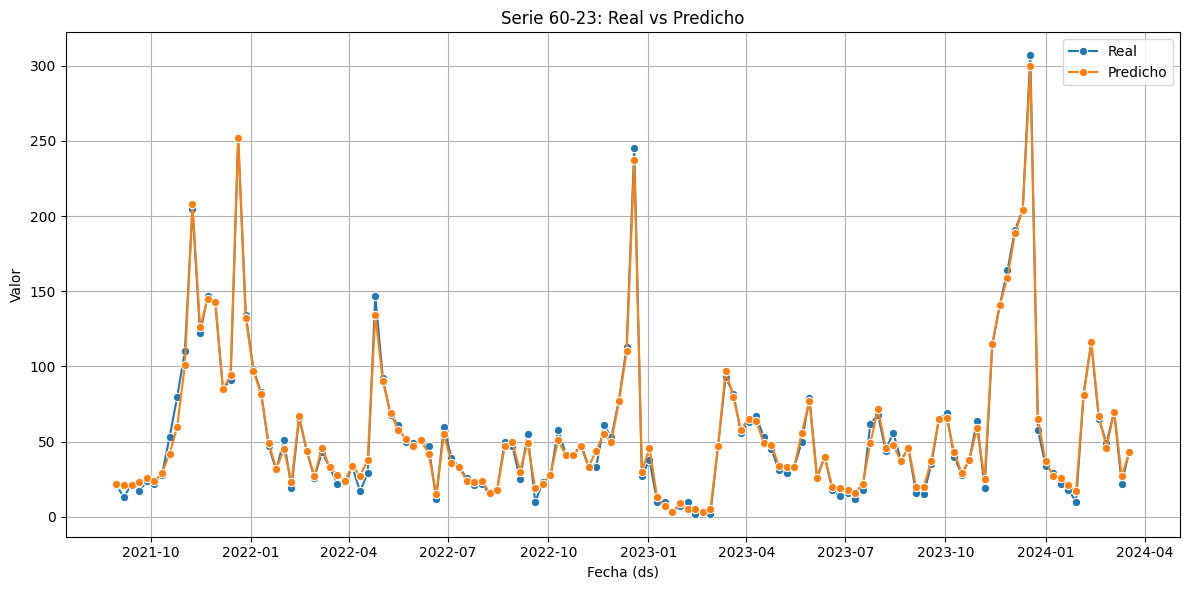

In [28]:
# graficar
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_train_filtered, x="ds", y=column_true, label="Real", marker="o")
sns.lineplot(data=df_train_filtered, x="ds", y=column_pred, label="Predicho", marker="o")

plt.title(f"Serie {serie_filter}: Real vs Predicho")
plt.xlabel("Fecha (ds)")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 7. Graficar real vs predicho - TEST - SE FORECASTEA HASTA UN HORIZONTE h=h - SE GENERA POR RECURSIVIDAD

In [29]:
# filtrar test
df_test_filtered = data_fcst_output_test[data_fcst_output_test["unique_id"] == serie_filter]

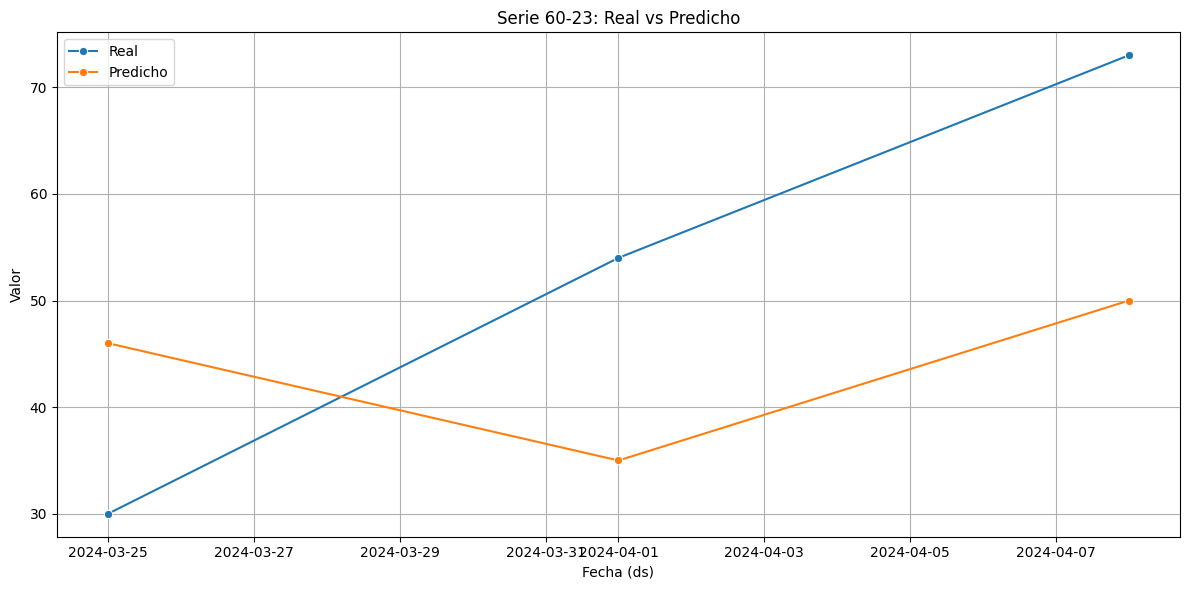

In [30]:
# graficar
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_test_filtered, x="ds", y=column_true, label="Real", marker="o")
sns.lineplot(data=df_test_filtered, x="ds", y=column_pred, label="Predicho", marker="o")

plt.title(f"Serie {serie_filter}: Real vs Predicho")
plt.xlabel("Fecha (ds)")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
a=1
a

1